In [1]:
from idaes.apps.grid_integration import PriceTakerModel
import pyomo.environ as pyo
import flowsheet as fs
import utils
from params import FlexDesalParams

In [2]:
# Create an instance of the PriceTakerModel
m = PriceTakerModel()

# Instantiate an object containing the model parameters
m.params = FlexDesalParams(
    start_date="2022-07-05 00:00:00",
    end_date="2022-07-15 00:00:00",
    annual_production_AF=1200,
)
m.params.intake.nominal_flowrate = 1063.5
m.params.ro.update({
    "startup_delay": 8,
    "minimum_downtime": 4,
    "nominal_flowrate": 337.670,
    "surrogate_type": "quadratic_surrogate",
    "surrogate_a": 11.509,
    "surrogate_b": -10.269,
    "surrogate_c": 5.627,
    "surrogate_d": 0,
    "minimum_recovery": 0.4,
    "nominal_recovery": 0.465,
    "maximum_recovery": 0.52,
})

In [4]:
import pandas as pd
price_data = pd.read_csv("sbce_pricesignal.csv")
price_data["Energy Rate"] = (
    price_data["electric_energy_0_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_1_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_2_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_3_2022-07-05_2022-07-14_0"]
)
price_data["Fixed Demand Rate"] = price_data["electric_demand_maximum_2022-07-05_2022-07-14_0"]
price_data["Var Demand Rate"] = price_data["electric_demand_peak-summer_2022-07-05_2022-07-14_0"]
price_data["Emissions Intensity"] = 0
price_data["Customer Cost"] = price_data["electric_customer_0_2022-07-05_2022-07-14_0"]

In [5]:
# Append LMP data to the model
m.append_lmp_data(lmp_data=price_data["Energy Rate"])

# Build the multiperiod model
m.build_multiperiod_model(
    flowsheet_func=fs.build_desal_flowsheet,
    flowsheet_options={"params": m.params},
)

# Update the time-varying parameters other than the LMP, such as
# demand costs and emissions intensity. LMP value is updated by default
m.update_operation_params({
    "fixed_demand_rate": price_data["Fixed Demand Rate"],
    "variable_demand_rate": price_data["Var Demand Rate"],
    "emissions_intensity": price_data["Emissions Intensity"],
    "customer_cost": price_data["Customer Cost"],
})

# Add demand cost and fixed cost calculation constraints
fs.add_demand_and_fixed_costs(m)

# Add the startup delay constraints
fs.add_delayed_startup_constraints(m)

# Construct useful expressions or model-level constraints
m.total_water_production = pyo.Expression(
    expr=m.params.timestep_hours * sum(m.period[:, :].posttreatment.product_flowrate)
)
m.total_energy_cost = pyo.Expression(expr=sum(m.period[:, :].energy_cost))
m.total_demand_cost = pyo.Expression(expr=m.fixed_demand_cost + m.variable_demand_cost)
m.total_customer_cost = pyo.Expression(expr=sum(m.period[:, :].customer_cost))
m.total_electricity_cost = pyo.Expression(
    expr=m.total_energy_cost + m.total_demand_cost + m.total_customer_cost
)

In [6]:
# Off-design operation is not allowed. Therefore the minimum stable operation
# range is the same as the capacity (i.e., op_range_lb = 1)
for skid in range(1, m.params.ro.num_ro_skids + 1):
    m.add_capacity_limits(
        op_block_name=f"reverse_osmosis.ro_skid[{skid}]",
        commodity="feed_flowrate",
        capacity=m.params.ro.nominal_flowrate,
        op_range_lb=1,
    )

2025-06-02 14:30:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity feed_flowrate in operation block reverse_osmosis.ro_skid[1] at ro_skid_1_feed_flowrate_limits
2025-06-02 14:30:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity feed_flowrate in operation block reverse_osmosis.ro_skid[2] at ro_skid_2_feed_flowrate_limits
2025-06-02 14:30:35 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created capacity limit constraints for commodity feed_flowrate in operation block reverse_osmosis.ro_skid[3] at ro_skid_3_feed_flowrate_limits


NOTE: If the minimum uptime = 1 and the minimum downtime = 1, then the minimum uptime and downtime constraints are not needed.
However, the startup variable is needed for delayed startup. So, we will add the minimum uptime and downtime constraints only
for one skid. These constraints are not needed for the remaining skids.

In [7]:
# Add startup and shutdown constraints for ro_skids
for skid in range(1, m.params.ro.num_ro_skids + 1):
    m.add_startup_shutdown(
        op_block_name=f"reverse_osmosis.ro_skid[{skid}]",
        up_time=m.params.ro.minimum_uptime,
        down_time=m.params.ro.minimum_downtime,
    )

2025-06-02 14:30:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  reverse_osmosis.ro_skid[1] at ro_skid_1_startup_shutdown.
2025-06-02 14:30:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  reverse_osmosis.ro_skid[2] at ro_skid_2_startup_shutdown.
2025-06-02 14:30:36 [INFO] idaes.apps.grid_integration.pricetaker.price_taker_model: Created startup/shutdown constraints for operation model  reverse_osmosis.ro_skid[3] at ro_skid_3_startup_shutdown.


In [8]:
# Feed flowrate to the intake is fixed, and it does not vary with time
m.fix_operation_var("intake.feed_flowrate", m.params.intake.nominal_flowrate)
m.fix_operation_var("pretreatment.op_mode", 1)

In [9]:
fs.constrain_water_production(m)

In [10]:
utils.fix_recovery(m, recovery=m.params.ro.nominal_recovery)

In [11]:
m.obj = pyo.Objective(
    expr=m.total_energy_cost + m.total_demand_cost,
    sense=pyo.minimize,
)

In [12]:
# # Use the following code to optimize for the net profit
# m.add_hourly_cashflows(
#     revenue_streams=["water_revenue", "demand_response_revenue"],
#     operational_costs=["emissions_cost", "energy_cost"],
# )
# m.add_overall_cashflows(
#     other_costs=[m.fixed_demand_cost, m.variable_demand_cost, m.fixed_monthly_cost]
# )

# m.add_objective_function(objective_type="net_profit")

In [13]:
# solver = utils.get_gurobi_solver_model(m, mip_gap=0.005)
solver = pyo.SolverFactory("gurobi")
solver.options["MIPGap"] = 0.03
solver.solve(m, tee=True)

Read LP format model from file C:\Users\RADHAK~1\AppData\Local\Temp\tmpan4z0yff.pyomo.lp
Reading time = 0.08 seconds
x1: 52790 rows, 42243 columns, 155568 nonzeros
Set parameter MIPGap to value 0.03
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13950HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.03

Optimize a model with 52790 rows, 42243 columns and 155568 nonzeros
Model fingerprint: 0x6b8f2559
Variable types: 31683 continuous, 10560 integer (10560 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  Objective range  [3e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+05]
Presolve removed 40000 rows and 33445 columns
Presolve time: 0.16s
Presolved: 12790 rows, 8798 columns, 49827 nonzeros
Variable types: 2882 continuous, 5916 integer (5756 binary)
Found heuristic so

{'Problem': [{'Name': 'x1', 'Lower bound': 33254.093937834936, 'Upper bound': 34282.381181530625, 'Number of objectives': 1, 'Number of constraints': 52790, 'Number of variables': 42243, 'Number of binary variables': 10560, 'Number of integer variables': 10560, 'Number of continuous variables': 31683, 'Number of nonzeros': 155568, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '1906.7809998989105', 'Error rc': 0, 'Time': 1907.8355689048767}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [14]:
m.get_operation_var_values().to_csv("dummy_result.csv")

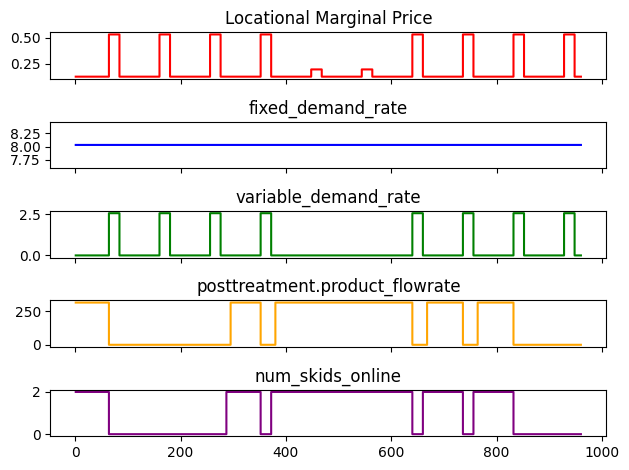

In [ ]:
fig, axs = m.plot_operation_profile(
    [
        "fixed_demand_rate",
        "variable_demand_rate",
        "posttreatment.product_flowrate",
        "num_skids_online",
    ],
)

axs[1].title("Variable Name")
fig.show()

In [16]:
m.get_design_var_values()

{'fixed_demand_cost': 3786.660320859862,
 'variable_demand_cost': 146.20051886385482,
 'fixed_monthly_cost': 247096.7741935484,
 'total_water_production': 40588.77817500001,
 'total_energy_cost': 30349.520341806947,
 'total_demand_cost': 3932.860839723717,
 'total_customer_cost': 3649.760000000066,
 'total_electricity_cost': 37932.14118153073}